In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Q1 

In [3]:
# Importing dataset
california = datasets.fetch_california_housing() 
# print(california.DESCR)
# type(california)
# returns a Bunch class
# see: https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html#sklearn.utils.Bunch

In [5]:
# california.keys()
california.data.shape
# california.target
# california.feature_names

(20640, 8)

Deriving design matrix

In [4]:
from sklearn.preprocessing import PolynomialFeatures

degree = 2

poly = PolynomialFeatures(degree,include_bias=True)
new_x = poly.fit_transform(california.data)
poly.get_feature_names_out(california.feature_names)

y = california.target

In [5]:
# check the martix shape
y.shape, new_x.shape, poly.get_feature_names_out(california.feature_names).shape

((20640,), (20640, 45), (45,))

Compute beta vector

In [6]:
# compute beta
beta = np.linalg.inv(np.transpose(new_x) @ new_x) @ np.transpose(new_x) @ y
beta.shape

(45,)

In [7]:
data = {
    'feature_name': poly.get_feature_names_out(california.feature_names),
    'coefficient': beta
}

df1 = pd.DataFrame(data)
df1.sort_values(by='coefficient')


,feature_name,coefficient
4,AveBedrms,-3.159133e+01
1,MedInc,-1.124302e+01
2,HouseAge,-8.488985e-01
33,AveBedrms Latitude,-4.370430e-01
34,AveBedrms Longitude,-4.041506e-01
12,MedInc AveBedrms,-1.861423e-01
15,MedInc Latitude,-1.525057e-01
16,MedInc Longitude,-1.442429e-01
32,AveBedrms AveOccup,-8.719115e-02
25,AveRooms AveBedrms,-6.890643e-02


# Q2 Lasso & Ridge Regression

In [8]:
df = pd.read_csv("./METABRIC_RNA_Mutation.csv", low_memory=False)
df_D = pd.concat([df['age_at_diagnosis'], df.iloc[:, 31:520]],axis=1)
D = df_D.to_numpy()
y = df['overall_survival_months'].to_numpy()

In [9]:
n = D.shape[0]
d = D.shape[1]

D.shape, y.shape

((1904, 490), (1904,))

# Self-defined ridge regression model with fit and pred methods.

In [10]:
from sklearn.base import BaseEstimator

class RidgeRegression(BaseEstimator):

    coef_ = np.random.rand(1)
    n = 0
    d = 0

    def __init__(self, alpha=0.1):
        self.alpha = alpha

    
    def fit(self, D, y):
        self.n = D.shape[0]
        self.d = D.shape[1]
        self.coef_ = np.linalg.inv(D.T @ D + 2 * self.n * self.alpha * np.identity(self.d) ) @ D.T @ y

    def predict(self, D):
        if not D[0].shape[0] == self.coef_.shape[0]:
            raise Exception("Please fit the data first or check your input.")
        return np.array(
            [np.dot(self.coef_, x) for x in D]
            )
    
    def get_params(self, deep=True):
        return {
            "alpha": self.alpha,
            # "coef_": self.coef_,
            # "n": self.n,
            # "d": self.d
        }


In [11]:
ridge = RidgeRegression(alpha=1)
ridge.fit(D, y)
ridge.predict(D)

array([140.60654997,  99.41957607, 112.54603918, ...,  86.36792445,
       111.36371303, 142.68887628])

# Self defined Grid-search

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import math

alpha = [0.000000001,0.000001,0.00001,0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5,6,7,8]
# alpha = [1, 2, 3, 4, 5, 6, 7, 8]

def gridsearch(param_range, folds, scoring, clf):

    kf = KFold(n_splits=folds)

    cv_test_score = []
    cv_train_score = []
    cv_feature = []

    for param in param_range:

        mse_test = []
        mse_train = []
        feature_selected = []

        for train, test in kf.split(D):
            X_train, X_test, y_train, y_test = D[train], D[test], y[train], y[test]
            cl = clf(alpha=param)
            cl.fit(X_train, y_train)
            y_pred_train = cl.predict(X_train)
            y_pred_test = cl.predict(X_test)
            mse_test.append(scoring(y_test, y_pred_test))
            mse_train.append(scoring(y_train, y_pred_train))
            feature_selected.append(np.count_nonzero(cl.coef_ > (10 ** (-16))))
            
        cv_test_score.append( np.mean(mse_test) ) 
        cv_train_score.append( np.mean(mse_train) ) 
        cv_feature.append( np.mean(feature_selected))
        
    return pd.DataFrame({
        'Param': param_range,
        'mean_train_score': cv_train_score,
        'mean_test_score': cv_test_score,
        'mean_feature': cv_feature
    })




In [13]:
ridge_df = gridsearch(alpha, 5, mean_squared_error, RidgeRegression)
ridge_df

,Param,mean_train_score,mean_test_score,mean_feature
0,1.000000e-09,3783.931632,10393.007034,253.2
1,1.000000e-06,3783.931632,10392.925882,253.2
2,1.000000e-05,3783.931670,10392.195042,253.2
3,1.000000e-03,3784.296064,10314.515077,252.8
4,1.000000e-02,3807.004407,9780.874137,253.6
5,1.000000e-01,4165.418987,8199.734952,255.4
6,5.000000e-01,4867.060404,7288.202038,247.8
7,1.000000e+00,5240.196855,7114.917808,243.8
8,2.000000e+00,5620.658692,7060.184968,242.4
9,3.000000e+00,5836.013330,7067.131263,243.0


In [14]:
lasso_df = gridsearch(alpha, 5, mean_squared_error, linear_model.Lasso)
lasso_df


/Users/keniwo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.700e+06, tolerance: 9.561e+02
  model = cd_fast.enet_coordinate_descent(
/Users/keniwo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e+06, tolerance: 7.990e+02
  model = cd_fast.enet_coordinate_descent(
/Users/keniwo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

,Param,mean_train_score,mean_test_score,mean_feature
0,1.000000e-09,3223.095654,8232.922577,246.6
1,1.000000e-06,3223.095653,8232.915495,246.6
2,1.000000e-05,3223.095648,8232.851692,246.6
3,1.000000e-03,3223.098214,8225.844750,246.2
4,1.000000e-02,3223.406424,8163.983793,244.8
5,1.000000e-01,3249.560671,7623.782635,223.4
6,5.000000e-01,3557.203217,6424.330878,155.0
7,1.000000e+00,3942.214091,5798.205600,95.4
8,2.000000e+00,4454.585144,5461.131326,43.0
9,3.000000e+00,4727.746522,5459.345097,21.4


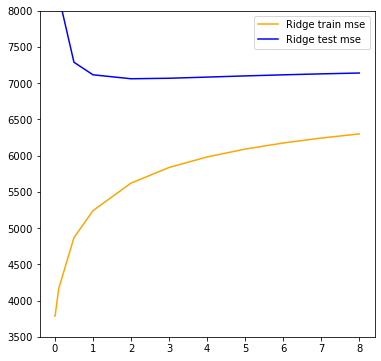

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(ridge_df.Param, ridge_df.mean_train_score, color='orange', label='Ridge train mse')
ax.plot(ridge_df.Param, ridge_df.mean_test_score, color='blue', label='Ridge test mse')

plt.legend()
plt.ylim([3500, 8000])
plt.show()

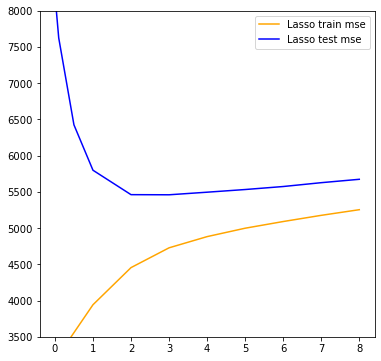

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(lasso_df.Param, lasso_df.mean_train_score, color='orange', label='Lasso train mse')
ax.plot(lasso_df.Param, lasso_df.mean_test_score, color='blue', label='Lasso test mse')

plt.legend()
plt.ylim([3500, 8000])
plt.show()

# Number of selected features

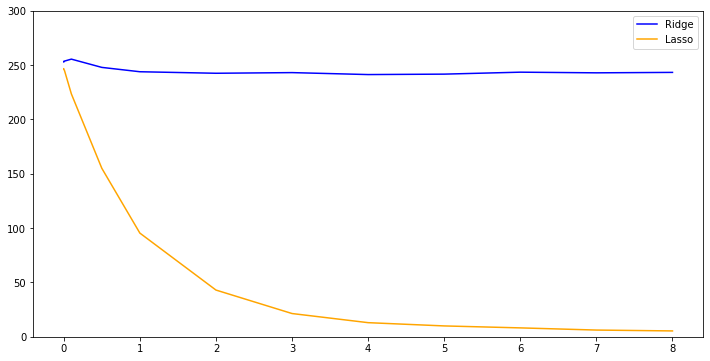

In [17]:

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ridge_df.Param, ridge_df.mean_feature, color='blue', label='Ridge')
ax.plot(lasso_df.Param, lasso_df.mean_feature, color='orange', label='Lasso')
# ax.plot(y, color='blue', label='Sine wave')
# ax.plot(z, color='black', label='Cosine wave')
plt.legend()

plt.ylim([0, 300])
plt.show()


# Q3

In [1]:
import math

tan=math.tan(0.1*math.pi)
print(tan)

y1 = 0
y2 = 0.4
y3 = 0.7
e = 1.1/3

bias = (tan-e)**2
print((tan-e)**2)

v = 0
v += (y1-e)**2
v += (y2-e)**2
v += (y3-e)**2
print(v/3)

0.3249196962329063
0.001742809540397266
0.08222222222222221


# Q5

|             | shape          | number of parameters |
|-------------|----------------|----------------------|
| input       | 64x64x3        | 0                    |
| padding     | 68x68x3        | 0                    |
| conv        | 64x64x16       | (5x5x3+1)x16=1216    |
| ReLU        | 64x64x16       | 0                    |
| max pooling | 31x31x16=15376 | 0                    |
| flatten     | 15376*1        | 0                    |
| output=2    |                | (15376+1)*2=30754    |
| total       |                | 608+30754=31970      |